# Project 1

Lirong Ma, Catherine Yang

Prior to running, update the following parameters:

In [1]:
# Filepaths to update
baby_names_path = "./namesbystate/"

# Update username, password, and host to connect to MySQL
user_input = "catherineyang"
password_input = "password" 
host_input = "localhost"

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

import pymysql

## Exercise 1

### BabyNames Class

In [3]:
class BabyNames():


    def __init__ (self, path):
        
        """
        The constuctor for BabyNames class
        
        Parameters:
            path : the file location to create Pandas DataFrame
            
        """
    
        columns = ['state', 'sex', 'year', 'name', 'num']
        
        self.df = pd.concat(
            [pd.read_csv(f, names = columns) for f in glob.glob(path+"*.TXT")],
            ignore_index = True,
            sort = False
        )
              
        
    def count(self, state = None, year = None):
    
        """
        The function to count the total number of births for a given state and year
        
        Parameters:
            state (optional) : a given state name. If it is None, count the total number of births for all states.
            year (optional) : a given year. If it is None, count the total number of births for all years.

        Returns:
            total number of births in a given state and year
        """
    
        data = self.df
        
        if (state == None) and (year == None):
            return data['num'].sum()
        elif state == None:
            return data[data.year == year].num.sum()
        elif year == None:
            return data[data.state == state].num.sum()
        else:
            return data[(data.year == year) & (data.state == state)].num.sum()

 
    def Top10BabyNames(self, state = None, year = None):

        """
        The function to find top 10 female and male baby names in a given state and a given year

        Parameters:
            state (optional) : a given state name. If it is None, consider the total number of births for all states.
            year (optional) : a given year. If it is None, consider the total number of births for all the years.

        Returns:
            result : a dataframe that contains top 10 female and male baby names 
        """
        
        data = self.df
        
        if (state is not None):
            data = data[data.state == state]

        if (year is not None):
            data = data[data.year == year]
        
        # "num" becomes the only column containing numeric data
        # when we use sum(), it will only show the sum of "num"
        
        # sum num and sort in descending order for female and male separately
        female = data[data.sex == 'F'].groupby('name').sum().reset_index().sort_values(by='num', ascending = False).head(10)
        male = data[data.sex == 'M'].groupby('name').sum().reset_index().sort_values(by='num', ascending = False).head(10)
        
        # combine results and save them in a data frame
        ranklst = list(range(1,11,1))
        femalelst = female['name'].tolist()
        malelst = male['name'].tolist()

        result = pd.DataFrame(list(zip(ranklst, malelst, femalelst)), columns = ['Rank', 'Male', 'Female'])  
        result = result.style.hide_index()

        return result
    
    
    def ChangeOfPopularity(self, fromYear=None, toYear=None, top=None):
        
        """
        The function prints three lists of baby names (male or female) that increased, decreased, 
        or stayed the same in popularity.

        Parameters:
            fromYear (optional) : a given starting year for the comparison. The default is the first year in the dataset 
            toYear (optional) : a given ending year for the comparison. The default is the last year in the dataset
            top (optional): a size of the three lists need to be returned. The default is 10.
            
        Returns:
            [increasinglst, decreasinglst, samelst] 
            increasinglst: a list of baby names that increased in popularity 
            decreasinglst: a list of baby names that decreased in popularity 
            samelst: a list of baby names that had the same popularity 
        """
        
        data = self.df
        
        # set parameters to default values if they are None
        if fromYear is None:
            fromYear = data.sort_values(by='year', ascending = True)['year'].values[0]

        if toYear is None:
            toYear = data.sort_values(by='year', ascending = False)['year'].values[0]
            
        if top is None:
            top = 10
        
        # aggregate num by year for each name
        pivot = data.pivot_table('num', index = 'name', columns = 'year', aggfunc = sum)
        data = pd.DataFrame(pivot.to_records())
        fromYear=str(fromYear)
        toYear=str(toYear)
        # keep values only for fromYear and toYear
        data = data[['name', fromYear, toYear]]
        # create a column to calculate percentage change between the two years
        # perchange in num = (toYear - fromYear)/fromYear*100
        data['perchange'] = np.nan

        # only consider names which have at least one birth in both fromYear and toYear
        # if there are no births in either fromYear or toYear, percentage change is NaN
        data.loc[(np.isnan(data[fromYear]) == False) & (np.isnan(data[toYear]) == False), 'perchange'] = (data[toYear] - data[fromYear]) / data[fromYear] * 100

        data = data.loc[np.isnan(data['perchange']) == False].reset_index().sort_values(by='perchange', ascending = False)
        
        increasing = data.head(top)
        increasinglst = list(increasing.name) 

        decreasing = data.tail(top)
        decreasinglst = list(decreasing.name) 

        same = data.loc[data['perchange'] == 0].head(top)
        samelst = list(same.name)

        print("Names that increased in popularity:\n", increasinglst)
        print("Names that decreased in popularity:\n ", decreasinglst)
        print("Names having the same popularity (excluding names having no occurrences both in fromYear and toYear):\n ", samelst)

        return [increasinglst, decreasinglst, samelst]

    
    def Top5NamesPerYear(self, year = None, sex = None):
                
        """
        The function returns a data frame that shows the five most frequent given names, by state, for male, female, 
        or both in a given year. The number to the right of each name is the number of occurrences in the data.

        Parameters:
            year (optional) : aggregating the number of occurrences for the given year. 
                              If it is None, consider all the years in the dataset.
            sex (optional) :  aggregating the number of occurrences for the given sex.
                              If it is None, consider both female and male occurrences.
            
        Returns:
            result : a data frame that shows the five most frequent given names, by state, for male, female, or both 
                     in a given year.
        """
        
        data = self.df
        
        if sex is not None:
            data = data[data['sex']==sex]
            
        if year is not None:
            data = data[data['year']==year]
        
        # after subsetting, year is no longer needed 
        data = data.drop(columns="year")
        # aggregate num for each name in each state
        pivot = data.pivot_table('num', index = 'name', columns = 'state', aggfunc = sum)
        data = pd.DataFrame(pivot.to_records())
        
        states = []
        names = []
        nums = []
        
        # create a data frame to build the table needs to be returned
        result = pd.DataFrame(columns=['State', 'Rank 1', 'Num 1', 'Rank 2', 'Num 2', 'Rank 3', 'Num 3', 
                                       'Rank 4', 'Num 4', 'Rank 5', 'Num 5'])
        
        # loop through columns (states) 
        for (columnName, columnData) in data.iteritems():
            
            # skip the 'name' column (which contains all the names in the dataset)
            if columnName != 'name':
                
                # get the top 5 names and occurrences for each state
                tmp = data.nlargest(5, columnName).reset_index()
                names = tmp['name'].tolist()
                nums = tmp[columnName].values

                result = result.append(pd.Series([columnName, names[0], nums[0], names[1], nums[1], 
                                                  names[2],nums[2], names[3], nums[3], names[4], nums[4]],
                                                index=result.columns), ignore_index=True)
                
        # format the caption for the data frame
        if year is None:
            year = "All Years"
        else:
            year = str(year)
            
        if sex is None:
            sex = "Female and Male"
        elif sex == 'F':
            sex = "Female"
        else:
            sex = "Male"
        
        result = result.style.hide_index().set_caption('Top Five %s Names for Births in %s' %(sex, year))
        
        return result
    
    
    def add_prop(self, group):
        
        """
        The function calculates the proportion of occurrences for each name 

        Parameter:
            group : a data frame where a proportion column needs to be added
            
        Returns:
            group : a data frame where a proportion column has been added
        """
        group['prop'] = group.num / group.num.sum()
        return group

    
    def NamePopularityPlot(self, name = None, yearRange = None, state = None, sex = None):
        
        """
        The function creates a plot that shows the name popularity changes over the year. 
        (popularity is based on the proportional use of the name within a state and a year)
        
        Parameters:
            name (optional): a given name for the popularity plot. The default is the first name in the datset.
            yearRange (optional): a given year range for the plot. The default is the maximum year range in the dataset. 
            state (optional): a given state within which the proportional use of the name needs to be plotted.
                              If it is None, calculate the proportional use in all states.
            sex (optional): only names associated with the given sex are considered. 
                            If it is None, both females and males are considered. 
        """
        data = self.df
        
        if name is None:
            name = data['name'][0]
        
        if state is not None:
            data = data[data.state == state]
        
        if sex is not None:
            data = data[data.sex == sex]
            
        if yearRange is None:
            tmp = data.sort_values(by = 'year', ascending = True)
            fromYear = tmp.head(1)['year'].values[0]
            toYear = tmp.tail(1)['year'].values[0]
            yearRange = (fromYear, toYear)
       
        # add a column for the proportion use of the name within a state and a year
        data = data.groupby(['state','year']).apply(self.add_prop)
        data = data[(data.name == name) & (data.year <= yearRange[1]) & (data.year >= yearRange[0])]
        data = data.pivot_table('prop', index = 'year', columns='name', aggfunc = sum)
        
        data.plot(title = 'Changes of Name Popularity over Years', figsize=(12,6))
            
            
    def NameFlip(self, n=None):
        
        """
        The function lists top n names that flipped over the years.
        
        A name flip is defined as a name changed from a girl name to a boy name or the reverse 
        in two consecutive years in the dataset. Please note a name might not have occurrences
        in some years, so the difference between two consecutive years in the dataset is not
        necessarily one. For example, 1980 and 1983 might be two consecutive years for a name, 
        since nobody was given the name in 1981 and 1982.
        
        A name is counted as a girl name in a year if female occurrences > male occurrences. 
        A name is counted as a boy name in a year if female occurrences <= male occurrences.
        
        Parameters:
            n (optional): the number of rows returned. The default is 10.
            
        Returns:
            result: a data frame which lists top n names that flipped over the years
        """
        
        if n is None:
            n = 10
        
        # group by name and year and aggregate sum of occurrences for each sex
        # fill missing values with 0
        data=self.df.groupby(['name','year','sex']).sum().unstack().reset_index().fillna(0)
        data.columns = ['name','year', 'F', 'M']
        # for each name, calculate the proportion of females who were given the name
        data['prop']=data['F']/(data['F']+data['M'])
        
        # dominant = 0 if a name is a girl name (female occurrences > male occurrences)
        # dominant = 1 if a name is a boy name  (female occurrences <= male occurrences)
        data.loc[data['prop'] > 0.5, 'dominant'] = 0
        data.loc[data['prop'] <= 0.5, 'dominant'] = 1
        data.sort_values(['name', 'year'], ascending=[True, True], inplace=True)
        
        # create a data frame to keep results
        result = pd.DataFrame(columns=('name', 'flips'))
        
        # get rid of names which were used by only females or only males over the years
        # calculate average dominant(binary) for each name
        # if average == 1, the name has only been used by males
        # if average == 0, the name has only been used by females
        pivot = data.pivot_table('dominant', index='name', aggfunc = np.mean)
        pivotdf = pd.DataFrame(pivot.to_records())
        subset = pivotdf[(pivotdf.dominant != 0) & (pivotdf.dominant != 1)]
        
        # get a list of names which have been used by both females and males
        names = subset['name'].unique()
        
        for name in names:
            nflips = 0
            # get a subset of data for the name
            namesubset = data[data.name == name]
            
            # loop through each row which corresponds to each year
            # compare each year with the year after
            for i in range(len(namesubset)-1):
                if namesubset.iloc[i]['dominant'] != namesubset.iloc[i+1]['dominant']:
                    nflips += 1
             
            result = result.append({'name': name, 'flips': nflips}, ignore_index=True)
    
        # sort results by # of name flips and get top n 
        result = result.sort_values(by='flips', ascending = False).head(n)
       
        names = result['name'].tolist()
        
        # get the subset of data for names which have top n name flips
        # for each name, plot the proportion of females given the name over years
        subset = data[data.name.isin(names)]
        pivot = subset.pivot_table('prop', index = 'year', columns='name', aggfunc = sum)          
        pivot.plot(title = 'Changes of Name Popularity over Years', figsize=(15,10))
        
        return result.style.hide_index()
        
        

### A story from the Baby Names dataset

In [4]:
# Read in the baby names data
names=BabyNames(baby_names_path)

Text(0, 0.5, 'Number of Births')

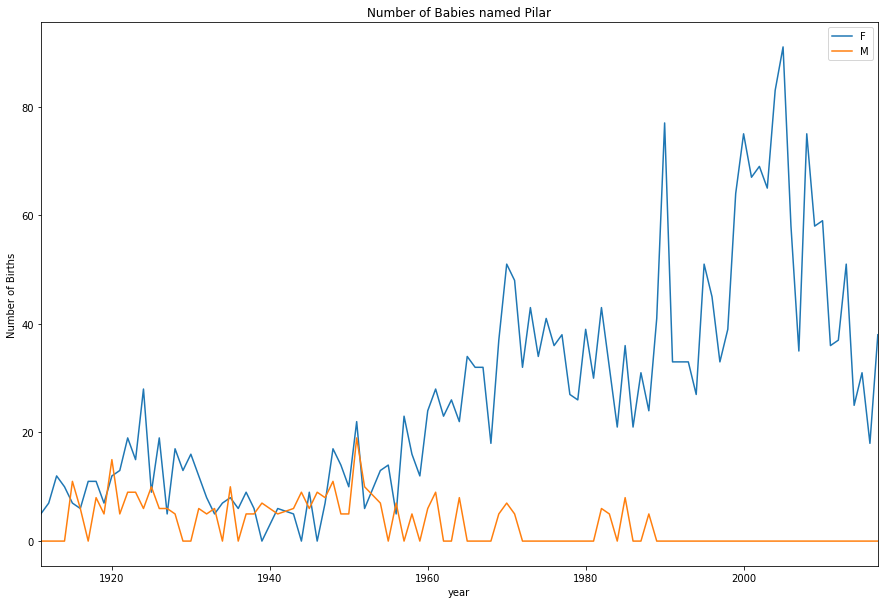

In [5]:
# Create a plot of the number of babies named Pilar for both male and female
data = names.df[names.df.name == "Pilar"]
data = data.groupby(['year','sex']).sum().unstack().reset_index().fillna(0)
data.columns = ['year', 'F', 'M']
data = data.set_index('year')
data.plot(figsize=(15,10))
plt.title("Number of Babies named Pilar")
plt.ylabel("Number of Births")

When we looked at the number of name flips, we noticed that the name Pilar started to become a predominantly female name around the 1950s and continued to rise in its predominance throughout the next couple of decades - in fact, the number of babies named Pilar even grew over that timeframe. We found that in 1967, the book "One Hundred Years of Solitude" was published by Gabriel Garcia Marquez, a widely acclaimed Latin American author, in which Pilar was a name of a female character in the story. We assume that due to the popularity of the novel (and perhaps other literary media for which Pilar was a featured name), prospective parents started to realize that Pilar was a befitting female name.

### Test all methods in BabyNames class

In [6]:
names=BabyNames(baby_names_path)

In [7]:
names.count(state='IL', year=2009)

135651

In [8]:
names.count()

308180519

In [9]:
names.Top10BabyNames(state='AL', year=2000)

Rank,Male,Female
1,William,Hannah
2,Jacob,Anna
3,Joshua,Madison
4,Christopher,Emily
5,Michael,Sarah
6,James,Alexis
7,John,Taylor
8,Matthew,Mary
9,Austin,Elizabeth
10,Tyler,Kayla


In [10]:
names.Top10BabyNames()

Rank,Male,Female
1,James,Mary
2,John,Patricia
3,Robert,Elizabeth
4,Michael,Jennifer
5,William,Linda
6,David,Barbara
7,Richard,Margaret
8,Joseph,Susan
9,Charles,Dorothy
10,Thomas,Jessica


In [11]:
names.ChangeOfPopularity(fromYear = 2014, toYear = 2015,top=10)

Names that increased in popularity:
 ['Kaiser', 'Bexley', 'Alaia', 'Riaan', 'Adaline', 'Meilani', 'Royalty', 'Aitana', 'Octavia', 'Charleston']
Names that decreased in popularity:
  ['Nevin', 'Female', 'Jessenia', 'Hala', 'Ethyn', 'Henrietta', 'Navaeh', 'Eldana', 'Jasen', 'Tayler']
Names having the same popularity (excluding names having no occurrences both in fromYear and toYear):
  ['Tilden', 'Lara', 'Adhya', 'Munira', 'Amery', 'Payden', 'Lavern', 'Anely', 'Arionna', 'Rosetta']


[['Kaiser',
  'Bexley',
  'Alaia',
  'Riaan',
  'Adaline',
  'Meilani',
  'Royalty',
  'Aitana',
  'Octavia',
  'Charleston'],
 ['Nevin',
  'Female',
  'Jessenia',
  'Hala',
  'Ethyn',
  'Henrietta',
  'Navaeh',
  'Eldana',
  'Jasen',
  'Tayler'],
 ['Tilden',
  'Lara',
  'Adhya',
  'Munira',
  'Amery',
  'Payden',
  'Lavern',
  'Anely',
  'Arionna',
  'Rosetta']]

In [12]:
names.Top5NamesPerYear(year = 2010, sex = 'F')

State,Rank 1,Num 1,Rank 2,Num 2,Rank 3,Num 3,Rank 4,Num 4,Rank 5,Num 5
AK,Sophia,62,Emma,51,Isabella,51,Olivia,44,Ava,33
AL,Emma,318,Isabella,254,Madison,251,Ava,218,Olivia,201
AR,Emma,202,Isabella,174,Addison,169,Chloe,139,Madison,137
AZ,Isabella,556,Sophia,516,Mia,376,Emma,336,Olivia,306
CA,Isabella,3366,Sophia,3360,Emily,2391,Mia,2016,Emma,1783
CO,Isabella,342,Sophia,317,Olivia,268,Emma,265,Abigail,245
CT,Isabella,278,Olivia,234,Sophia,231,Ava,192,Emma,192
DC,Madison,50,Olivia,43,Charlotte,37,Ashley,35,Ava,34
DE,Sophia,73,Isabella,66,Ava,64,Olivia,45,Emily,40
FL,Isabella,1837,Sophia,1248,Olivia,889,Emma,838,Emily,817


In [13]:
names.Top5NamesPerYear(year = 2012)

State,Rank 1,Num 1,Rank 2,Num 2,Rank 3,Num 3,Rank 4,Num 4,Rank 5,Num 5
AK,Emma,57,Sophia,56,James,52,Olivia,49,Ethan,47
AL,William,437,James,321,Emma,320,Mason,303,John,280
AR,William,217,Emma,186,Sophia,165,Mason,157,James,154
AZ,Sophia,589,Isabella,490,Emma,394,Jacob,393,Liam,382
CA,Sophia,3643,Isabella,3109,Jacob,2978,Jayden,2966,Daniel,2684
CO,Liam,355,Emma,337,Sophia,331,Olivia,317,Alexander,300
CT,Emma,246,Olivia,235,Isabella,234,Mason,230,Sophia,227
DC,William,94,Alexander,67,Henry,65,John,64,James,59
DE,Sophia,67,Isabella,65,Emma,63,Michael,60,Anthony,55
FL,Isabella,1586,Sophia,1374,Jayden,1193,Jacob,1080,Emma,1071


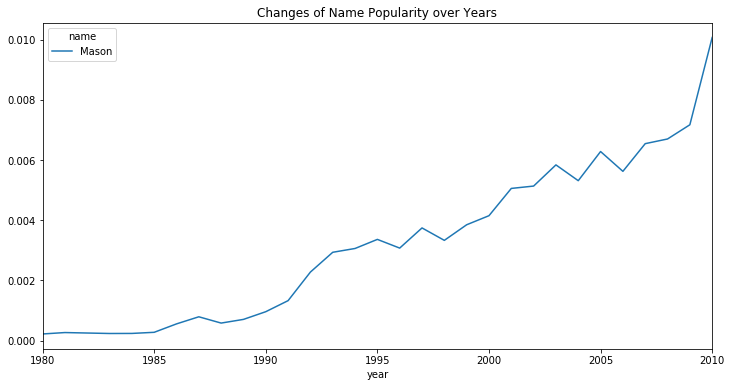

In [14]:
names.NamePopularityPlot(name = 'Mason', yearRange = (1980, 2010), state = 'AL', sex = 'M')

name,flips
Natividad,28
Lorenza,28
Pilar,22


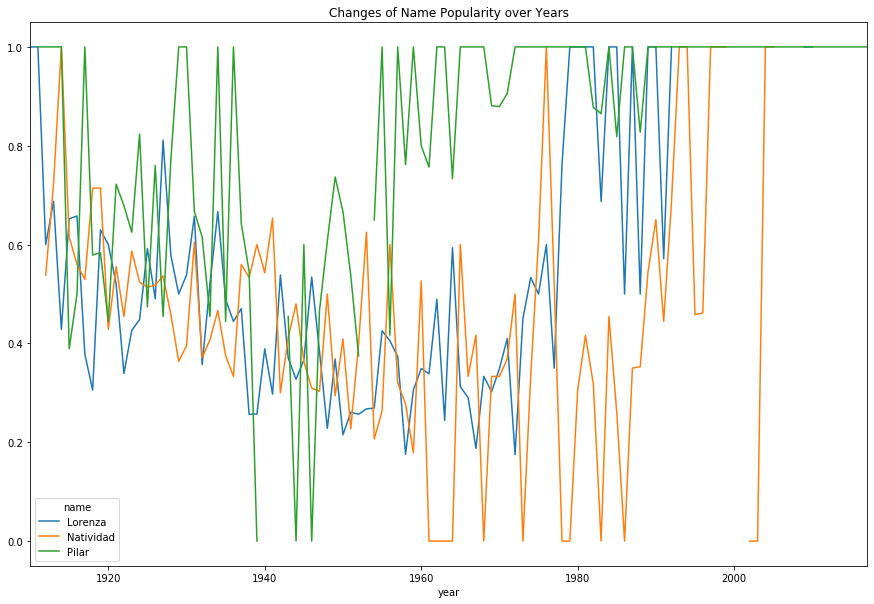

In [15]:
names.NameFlip(n=3)

## Exercise 2

Using MySQL and the sample database “WORLD”, your tasks are:
1. Translate the following SQL commands into Pandas library commands.
2. Make sure to compare results
3. Provide a description of what each SQL statement intends to do.

### Read in Data from MySQL

In [16]:
# Connect to MySQL
cnx = pymysql.connect(user=user_input, \
      password=password_input, \
      host=host_input, \
      db='world', \
      autocommit=True)

# Create pandas dataframe for the Country table
df_country = pd.read_sql_query('select * from Country', con=cnx)

# Create pandas dataframe for the City table
df_city = pd.read_sql_query('select * from city', con=cnx)

# Create pandas dataframe for Country Language table
df_language = pd.read_sql_query('select * from countrylanguage', con=cnx)

In [17]:
# See what columns are contained within each dataframe/table
print(df_country.columns)
print(df_city.columns)
print(df_language.columns)

Index(['Code', 'Name', 'Continent', 'Region', 'SurfaceArea', 'IndepYear',
       'Population', 'LifeExpectancy', 'GNP', 'GNPOld', 'LocalName',
       'GovernmentForm', 'HeadOfState', 'Capital', 'Code2'],
      dtype='object')
Index(['ID', 'Name', 'CountryCode', 'District', 'Population'], dtype='object')
Index(['CountryCode', 'Language', 'IsOfficial', 'Percentage'], dtype='object')


### Question 1:

**SQL Query:**
<br>select *
<br>from country
<br>where population > 50000000
<br>order by population DESC limit 10

In [18]:
# Pandas command
pd_df_q1 = (
    df_country[df_country.Population > 50000000] # subset for countries with population > 50M
    .sort_values(by="Population", ascending=False) # sort by 'Population' in descending order
    .reset_index() # reset the index to be consistent with SQL query
    .drop(columns="index") # drop 'index' column
    .head(10)
)
pd_df_q1

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523.0,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891.0,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947.0,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109.0,IN
2,USA,United States,North America,North America,9363520.0,1776.0,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813.0,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945.0,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939.0,ID
4,BRA,Brazil,South America,South America,8547403.0,1822.0,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211.0,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947.0,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831.0,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991.0,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580.0,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971.0,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150.0,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660.0,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532.0,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960.0,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754.0,NG


In [19]:
# MySQL query comparison
sq_df_q1 = pd.read_sql_query(
    "select * " + 
    "from country " +
    "where population > 50000000 " + 
    "order by population DESC " + 
    "limit 10",
    con=cnx,
)
sq_df_q1

,Code,Name,Continent,Region,SurfaceArea,IndepYear,Population,LifeExpectancy,GNP,GNPOld,LocalName,GovernmentForm,HeadOfState,Capital,Code2
0,CHN,China,Asia,Eastern Asia,9572900.0,-1523,1277558000,71.4,982268.0,917719.0,Zhongquo,People'sRepublic,Jiang Zemin,1891,CN
1,IND,India,Asia,Southern and Central Asia,3287263.0,1947,1013662000,62.5,447114.0,430572.0,Bharat/India,Federal Republic,Kocheril Raman Narayanan,1109,IN
2,USA,United States,North America,North America,9363520.0,1776,278357000,77.1,8510700.0,8110900.0,United States,Federal Republic,George W. Bush,3813,US
3,IDN,Indonesia,Asia,Southeast Asia,1904569.0,1945,212107000,68.0,84982.0,215002.0,Indonesia,Republic,Abdurrahman Wahid,939,ID
4,BRA,Brazil,South America,South America,8547403.0,1822,170115000,62.9,776739.0,804108.0,Brasil,Federal Republic,Fernando Henrique Cardoso,211,BR
5,PAK,Pakistan,Asia,Southern and Central Asia,796095.0,1947,156483000,61.1,61289.0,58549.0,Pakistan,Republic,Mohammad Rafiq Tarar,2831,PK
6,RUS,Russian Federation,Europe,Eastern Europe,17075400.0,1991,146934000,67.2,276608.0,442989.0,Rossija,Federal Republic,Vladimir Putin,3580,RU
7,BGD,Bangladesh,Asia,Southern and Central Asia,143998.0,1971,129155000,60.2,32852.0,31966.0,Bangladesh,Republic,Shahabuddin Ahmad,150,BD
8,JPN,Japan,Asia,Eastern Asia,377829.0,-660,126714000,80.7,3787042.0,4192638.0,Nihon/Nippon,Constitutional Monarchy,Akihito,1532,JP
9,NGA,Nigeria,Africa,Western Africa,923768.0,1960,111506000,51.6,65707.0,58623.0,Nigeria,Federal Republic,Olusegun Obasanjo,2754,NG


**Explanation:** This query selects all information from countries with a population greater than 50,000,000 and keeps the top 10 countries with the largest population, sorted in descending order by population.

### Question 2:

**SQL Query:**
<br>select Continent, count(*) As Number_Countries, sum(population) As Population 
<br>from country
<br>where population > 0
<br>group by Continent
<br>order by 1 ASC

In [20]:
# Pandas command
pd_df_q2 = (
    df_country[df_country.Population > 0] # subset for countries with population > 0
    .groupby("Continent") 
    .agg({"Name": "count", "Population": "sum"}) # get the count of continent names and sum of the continent populations
    .rename(columns={"Name": "Number_Countries"}) 
    .reset_index() # reset index to be consistent with SQL query
    .sort_values(by="Continent", ascending=True)
)
pd_df_q2

,Continent,Number_Countries,Population
0,Africa,57,784475000
1,Asia,51,3705025700
2,Europe,46,730074600
3,North America,37,482993000
4,Oceania,27,30401150
5,South America,14,345780000


In [21]:
# MySQL query comparison
sq_df_q2 = pd.read_sql_query(
    "select Continent, count(*) As Number_Countries, sum(population) As Population " +
    "from country " +
    "where population > 0 " + 
    "group by Continent " +
    "order by 1 ASC",
    con=cnx,
)
sq_df_q2

,Continent,Number_Countries,Population
0,Asia,51,3.705026e+09
1,Europe,46,7.300746e+08
2,North America,37,4.829930e+08
3,Africa,57,7.844750e+08
4,Oceania,27,3.040115e+07
5,South America,14,3.457800e+08


**Explanation:** This query obtains a list of continents, the number of countries in the continent, and the total population of the continent, sorted in ascending alphabetical order of the continent name. There appears to be something going on with the SQL query, which doesn't seem to be sorted in alphabetical order (Africa is in the wrong position).

### Question 3:

**SQL Query**
<br>select city.Name As City, city.population
<br>from city
<br>inner join country ON city.CountryCode = country.code
<br>where country.code = 'USA'
<br>order by city.population DESC limit 10

In [23]:
# Pandas command
pd_df_q3 = (
    pd.merge(
        df_city,
        df_country,
        how="inner",
        left_on="CountryCode",
        right_on="Code",
        copy=False,
    ) # merge the datasets using an inner join
    .rename(columns={"Name_x": "City", "Population_x": "City_Population"})
    .query("CountryCode == 'USA'") # subset for "USA"
    .loc[:, ["City", "City_Population"]] # select only "City" and "City_Population" columns
    .sort_values(by="City_Population", ascending=False) # sort by population in descending order
    .reset_index() # reset index to be consistent with SQL query
    .drop(columns=["index"]) # drop "index column"
    .head(10) # get only the first 10 rows
)
pd_df_q3

,City,City_Population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


In [24]:
# MySQL query comparison
sq_df_q3 = pd.read_sql_query(
    "select city.Name As City, city.population " +
    "from city inner join country ON city.CountryCode = country.code " +
    "where country.code = 'USA' " +
    "order by city.population DESC limit 10", con=cnx)
sq_df_q3

,City,population
0,New York,8008278
1,Los Angeles,3694820
2,Chicago,2896016
3,Houston,1953631
4,Philadelphia,1517550
5,Phoenix,1321045
6,San Diego,1223400
7,Dallas,1188580
8,San Antonio,1144646
9,Detroit,951270


**Explanation:** This query obtains the city name and population of the top 10 US cities by population and sorts by population in descending order. 

### Question 4

**SQL Query**
<br>select country.Name, Language, (Percentage * population) / 100
<br>from countrylanguage
<br>inner join country on countrylanguage.CountryCode = country.code
<br>where IsOfficial = True
<br>order by 3 DESC limit 10

In [26]:
# Pandas command
pd_df_q4 = (
    pd.merge(
        df_country,
        df_language,
        how="inner",
        left_on="Code",
        right_on="CountryCode",
        copy=False,
    ) # merge the dataframe using inner join
    .query("IsOfficial=='T'") # subset where "IsOfficial" is true
    .assign(Num_Speakers=lambda x: x.Percentage * x.Population / 100) # create new column that is the percentage * populcation / 100
    .loc[:, ["Name", "Language", "Num_Speakers"]] # select the "Name", "Language", and "Num_Speakers" columns
    .sort_values(by="Num_Speakers", ascending=False)
    .reset_index() # reset index to be consistent with SQL query
    .drop(columns="index") # drop "index" column
    .head(10)
)
pd_df_q4

,Name,Language,Num_Speakers
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044511e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


Note that the ((Percentage * population) / 100) column was named as "Num_Speakers" in the pandas command to make it easier to manipulate.

In [27]:
# MySQL query comparison
sq_df_q4 = pd.read_sql_query(
    "select country.Name, Language, (Percentage * population) / 100 " +
    "from countrylanguage " +
    "inner join country on countrylanguage.CountryCode = country.code " +
    "where IsOfficial = True " +
    "order by 3 DESC limit 10", con=cnx)
sq_df_q4

,Name,Language,(Percentage * population) / 100
0,China,Chinese,1.175353e+09
1,India,Hindi,4.044512e+08
2,United States,English,2.399437e+08
3,Brazil,Portuguese,1.658621e+08
4,Russian Federation,Russian,1.272448e+08
5,Bangladesh,Bengali,1.261844e+08
6,Japan,Japanese,1.255736e+08
7,Mexico,Spanish,9.106940e+07
8,Germany,German,7.501637e+07
9,Vietnam,Vietnamese,6.929418e+07


**Explanation:** This query obtains the country, official language, and number of people in the country who speak the language, of the top 10 most frequent languages spoken in a country, sorted by number of speakers in descending order.

### Question 5

**SQL Query**
<br>select Language, sum((Percentage * population) / 100)
<br>from countrylanguage
<br>inner join country ON countrylanguage.CountryCode = country.code
<br>group by Language
<br>order by 2 desc limit 5

In [28]:
# Pandas command
pd_df_5 = (
    pd.merge(
        df_country, df_language, how="inner", left_on="Code", right_on="CountryCode"
    ) # merge the dataframes
    .assign(Num_Speakers=lambda x: x.Percentage * x.Population / 100) # create new column that is percentage * population / 100
    .groupby("Language")
    .agg({"Num_Speakers": "sum"}) # sum the number of speakers for each language
    .sort_values(by="Num_Speakers", ascending=False)
    .reset_index() # reset the index to be consistent with SQL query
    .head(5)
)
pd_df_5

,Language,Num_Speakers
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08


Note that the sum((Percentage * population) / 100) column was named as "Num_Speakers" in the pandas command to make it easier to manipulate.

In [29]:
# MySQL query comparison
sq_df_q5 = pd.read_sql_query(
    "select Language, sum((Percentage * population) / 100) " +
    "from countrylanguage " +
    "inner join country on countrylanguage.CountryCode = country.code " +
    "group by Language " +
    "order by 2 DESC limit 5", con=cnx)
sq_df_q5

,Language,sum((Percentage * population) / 100)
0,Chinese,1.191844e+09
1,Hindi,4.056331e+08
2,Spanish,3.550295e+08
3,English,3.470779e+08
4,Arabic,2.338392e+08


**Explanation:** This query obtains the language and its number of speakers worldwide of the top 5 languages spoken, sorted in descending order by number of language speakers.